In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import warnings
import geopandas
warnings.simplefilter("ignore")

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import chi2_contingency
from scipy import stats

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix



from matplotlib.collections import LineCollection
from fonctions import *

# 1 - DATAFRAME (création et nettoyage)

In [2]:
# Liste des colonnes non nécessaires qu'on supprimera à l'importation
drop_columns = ['Domaine','Code zone','Code Domaine', 'Code Élément', 'Code Produit', 'Symbole', 'Description du Symbole','Unité','Code année']

df_dispoAli = pd.read_csv(r'DisponibiliteAlimentaire_2017.csv', decimal=".").drop(drop_columns, axis=1)
df_dispoAli.head()

,Zone,Élément,Produit,Année,Valeur
0,Afghanistan,Production,Blé et produits,2017,4281.0
1,Afghanistan,Importations - Quantité,Blé et produits,2017,2302.0
2,Afghanistan,Variation de stock,Blé et produits,2017,-119.0
3,Afghanistan,Exportations - Quantité,Blé et produits,2017,0.0
4,Afghanistan,Disponibilité intérieure,Blé et produits,2017,6701.0


In [3]:
df_dispoAli.info() #Aucune valeur manquante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176600 entries, 0 to 176599
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Zone     176600 non-null  object 
 1   Élément  176600 non-null  object 
 2   Produit  176600 non-null  object 
 3   Année    176600 non-null  int64  
 4   Valeur   176600 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 6.7+ MB


In [4]:
df_dispoAli.isnull().sum()

Zone       0
Élément    0
Produit    0
Année      0
Valeur     0
dtype: int64

In [5]:
# Nous n'avons besoin que des produits de viande de volailles
#Nous ne selectionnerons que les données de productions, importation, et dispo en proteine

df = df_dispoAli.loc[(df_dispoAli['Produit'] == 'Viande de Volailles')]
df_poulet = df.loc[(df['Élément'] == 'Production') | (df['Élément'] == 'Importations - Quantité') | (df['Élément'] == 'Disponibilité de protéines en quantité (g/personne/jour)') | (df['Élément'] == 'Importations - Quantité') | (df['Élément'] == 'Disponibilité intérieure')| (df['Élément'] == 'Disponibilité alimentaire en quantité (kg/personne/an)') | (df['Élément'] =='Disponibilité alimentaire (Kcal/personne/jour)')]
df_poulet

,Zone,Élément,Produit,Année,Valeur
651,Afghanistan,Production,Viande de Volailles,2017,28.00
652,Afghanistan,Importations - Quantité,Viande de Volailles,2017,29.00
654,Afghanistan,Disponibilité intérieure,Viande de Volailles,2017,57.00
658,Afghanistan,Disponibilité alimentaire en quantité (kg/pers...,Viande de Volailles,2017,1.53
659,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),Viande de Volailles,2017,5.00
...,...,...,...,...,...
176389,Zimbabwe,Importations - Quantité,Viande de Volailles,2017,6.00
176391,Zimbabwe,Disponibilité intérieure,Viande de Volailles,2017,76.00
176397,Zimbabwe,Disponibilité alimentaire en quantité (kg/pers...,Viande de Volailles,2017,4.68
176398,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),Viande de Volailles,2017,16.00


In [6]:
#Création de la variable Dispo alimentaire de tous les éléments

df = df_dispoAli.loc[(df_dispoAli['Élément'] == 'Disponibilité alimentaire (Kcal/personne/jour)')]
df['Produit'] = 'Total'
df_dispo_ali = df.groupby(['Zone', 'Élément', 'Produit', 'Année']).sum().reset_index()
df_dispo_ali

,Zone,Élément,Produit,Année,Valeur
0,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),Total,2017,1997.0
1,Afrique du Sud,Disponibilité alimentaire (Kcal/personne/jour),Total,2017,2987.0
2,Albanie,Disponibilité alimentaire (Kcal/personne/jour),Total,2017,3400.0
3,Algérie,Disponibilité alimentaire (Kcal/personne/jour),Total,2017,3345.0
4,Allemagne,Disponibilité alimentaire (Kcal/personne/jour),Total,2017,3559.0
...,...,...,...,...,...
167,Émirats arabes unis,Disponibilité alimentaire (Kcal/personne/jour),Total,2017,3370.0
168,Équateur,Disponibilité alimentaire (Kcal/personne/jour),Total,2017,2585.0
169,États-Unis d'Amérique,Disponibilité alimentaire (Kcal/personne/jour),Total,2017,3762.0
170,Éthiopie,Disponibilité alimentaire (Kcal/personne/jour),Total,2017,2304.0


In [7]:
#Création de la variable Dispo en proteine en quantité de tous les éléments

df = df_dispoAli.loc[(df_dispoAli['Élément'] == 'Disponibilité de protéines en quantité (g/personne/jour)')]
df['Produit'] = 'Total'
df_dispo_prot = df.groupby(['Zone', 'Élément', 'Produit', 'Année']).sum().reset_index()
df_dispo_prot

,Zone,Élément,Produit,Année,Valeur
0,Afghanistan,Disponibilité de protéines en quantité (g/pers...,Total,2017,54.09
1,Afrique du Sud,Disponibilité de protéines en quantité (g/pers...,Total,2017,83.36
2,Albanie,Disponibilité de protéines en quantité (g/pers...,Total,2017,119.50
3,Algérie,Disponibilité de protéines en quantité (g/pers...,Total,2017,92.85
4,Allemagne,Disponibilité de protéines en quantité (g/pers...,Total,2017,104.07
...,...,...,...,...,...
167,Émirats arabes unis,Disponibilité de protéines en quantité (g/pers...,Total,2017,107.26
168,Équateur,Disponibilité de protéines en quantité (g/pers...,Total,2017,65.77
169,États-Unis d'Amérique,Disponibilité de protéines en quantité (g/pers...,Total,2017,113.61
170,Éthiopie,Disponibilité de protéines en quantité (g/pers...,Total,2017,65.64


In [8]:
#Donnée de population 

drop_columns = ['Domaine','Code zone','Code Domaine', 'Code Élément', 'Code Produit', 'Symbole', 'Description du Symbole','Unité','Code année']

df_population = pd.read_csv(r'Population_2000_2018.csv', decimal=".").drop(drop_columns, axis=1)
df_population

,Zone,Élément,Produit,Année,Valeur,Note
0,Afghanistan,Population totale,Population-Estimations,2000,20779.953,NaN
1,Afghanistan,Population totale,Population-Estimations,2001,21606.988,NaN
2,Afghanistan,Population totale,Population-Estimations,2002,22600.770,NaN
3,Afghanistan,Population totale,Population-Estimations,2003,23680.871,NaN
4,Afghanistan,Population totale,Population-Estimations,2004,24726.684,NaN
...,...,...,...,...,...,...
4406,Zimbabwe,Population totale,Population-Estimations,2014,13586.707,NaN
4407,Zimbabwe,Population totale,Population-Estimations,2015,13814.629,NaN
4408,Zimbabwe,Population totale,Population-Estimations,2016,14030.331,NaN
4409,Zimbabwe,Population totale,Population-Estimations,2017,14236.595,NaN


In [9]:
#Comme nos données sont tous sur l'année 2017, on selectionne celle ci 
#Et on prends 2007 egalement pour voir l'evolution sur 10 ans

df_population = df_population.loc[(df_population['Année'] == 2007) |(df_population['Année'] == 2017)]
df_population

,Zone,Élément,Produit,Année,Valeur,Note
7,Afghanistan,Population totale,Population-Estimations,2007,27100.536,NaN
17,Afghanistan,Population totale,Population-Estimations,2017,36296.113,NaN
26,Afrique du Sud,Population totale,Population-Estimations,2007,49119.759,NaN
36,Afrique du Sud,Population totale,Population-Estimations,2017,57009.756,NaN
45,Albanie,Population totale,Population-Estimations,2007,3033.998,NaN
...,...,...,...,...,...,...
4371,Yémen,Population totale,Population-Estimations,2017,27834.819,NaN
4380,Zambie,Population totale,Population-Estimations,2007,12502.958,NaN
4390,Zambie,Population totale,Population-Estimations,2017,16853.599,NaN
4399,Zimbabwe,Population totale,Population-Estimations,2007,12255.922,NaN


In [10]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 7 to 4409
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Zone     466 non-null    object 
 1   Élément  466 non-null    object 
 2   Produit  466 non-null    object 
 3   Année    466 non-null    int64  
 4   Valeur   466 non-null    float64
 5   Note     7 non-null      object 
dtypes: float64(1), int64(1), object(4)
memory usage: 25.5+ KB


In [11]:
drop_columns = ['Domaine','Code zone (M49)','Code Domaine', 'Code Élément', 'Code Produit', 'Symbole', 'Description du Symbole','Unité','Code année']
df_secu = pd.read_csv('PIB_Political_Stability_2017.csv', decimal=".", delimiter = ";").drop(drop_columns, axis=1) # Données de la sécurité alimentaire
#df_secu= df_secu. rename(columns={'Code zone (M49)': 'Code zone'})
df_secu

,Zone,Élément,Produit,Année,Valeur,Note
0,Afghanistan,Valeur,"PIB par habitant, ($ PPA internationaux consta...",2017,2058.40,NaN
1,Afghanistan,Valeur,Stabilité politique et absence de violence/ter...,2007,-2.41,NaN
2,Afghanistan,Valeur,Stabilité politique et absence de violence/ter...,2017,-2.80,NaN
3,Afrique du Sud,Valeur,"PIB par habitant, ($ PPA internationaux consta...",2017,13860.30,NaN
4,Afrique du Sud,Valeur,Stabilité politique et absence de violence/ter...,2007,0.22,NaN
...,...,...,...,...,...,...
759,Ouzbékistan,Valeur,"PIB par habitant, ($ PPA internationaux consta...",2007,4185.60,NaN
760,Vanuatu,Valeur,"PIB par habitant, ($ PPA internationaux consta...",2007,3248.40,NaN
761,Viet Nam,Valeur,"PIB par habitant, ($ PPA internationaux consta...",2007,4628.00,NaN
762,Zambie,Valeur,"PIB par habitant, ($ PPA internationaux consta...",2007,2747.40,NaN


In [12]:
df_secu.info() #Aucune Valeur manquantes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Zone     764 non-null    object 
 1   Élément  764 non-null    object 
 2   Produit  764 non-null    object 
 3   Année    764 non-null    int64  
 4   Valeur   764 non-null    float64
 5   Note     0 non-null      float64
dtypes: float64(2), int64(1), object(3)
memory usage: 35.9+ KB


In [13]:
df_dispo_prot_ani = pd.read_csv('Dispo_Prot_Animal_2017.csv').drop(drop_columns, axis=1) # Données de la sécurité alimentaire
#Changement de 2016-2018 par 2017
df_dispo_prot_ani['Année'] = 2017
#Changement du nom Code Zone pour une harmonisation
df_dispo_prot_ani= df_dispo_prot_ani. rename(columns={'Code zone (M49)': 'Code zone'})
df_dispo_prot_ani['Produit'] = 'Dispo Proteines moyen (3 ans)'
df_dispo_prot_ani


,Zone,Élément,Produit,Année,Valeur,Note
0,Afghanistan,Valeur,Dispo Proteines moyen (3 ans),2017,10.7,NaN
1,Afrique du Sud,Valeur,Dispo Proteines moyen (3 ans),2017,35.7,NaN
2,Albanie,Valeur,Dispo Proteines moyen (3 ans),2017,61.0,NaN
3,Algérie,Valeur,Dispo Proteines moyen (3 ans),2017,25.0,NaN
4,Allemagne,Valeur,Dispo Proteines moyen (3 ans),2017,63.0,NaN
...,...,...,...,...,...,...
199,Venezuela (République bolivarienne du),Valeur,Dispo Proteines moyen (3 ans),2017,24.0,NaN
200,Viet Nam,Valeur,Dispo Proteines moyen (3 ans),2017,32.0,NaN
201,Yémen,Valeur,Dispo Proteines moyen (3 ans),2017,9.7,NaN
202,Zambie,Valeur,Dispo Proteines moyen (3 ans),2017,13.7,NaN


In [14]:
df_dispo_prot_ani.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Zone     204 non-null    object 
 1   Élément  204 non-null    object 
 2   Produit  204 non-null    object 
 3   Année    204 non-null    int64  
 4   Valeur   166 non-null    float64
 5   Note     0 non-null      float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.7+ KB


In [15]:
def doublons(df): # Nombre de doublons dans la dataframe
    print(len(df) - len(df.drop_duplicates()), 'doublons dans le dataframe ')

for i in [df_poulet,df_dispo_ali,df_dispo_prot, df_population, df_secu,df_dispo_prot_ani]:
    doublons(i)

0 doublons dans le dataframe 
0 doublons dans le dataframe 
0 doublons dans le dataframe 
0 doublons dans le dataframe 
0 doublons dans le dataframe 
0 doublons dans le dataframe 


In [16]:
#Concatenation de toutes les dataframes créées juste avant. sous l'appelation data

data = pd.concat([df_dispo_prot, df_dispo_ali, df_poulet, df_secu, df_population,df_dispo_prot_ani]) # Concaténation
data

,Zone,Élément,Produit,Année,Valeur,Note
0,Afghanistan,Disponibilité de protéines en quantité (g/pers...,Total,2017,54.09,NaN
1,Afrique du Sud,Disponibilité de protéines en quantité (g/pers...,Total,2017,83.36,NaN
2,Albanie,Disponibilité de protéines en quantité (g/pers...,Total,2017,119.50,NaN
3,Algérie,Disponibilité de protéines en quantité (g/pers...,Total,2017,92.85,NaN
4,Allemagne,Disponibilité de protéines en quantité (g/pers...,Total,2017,104.07,NaN
...,...,...,...,...,...,...
199,Venezuela (République bolivarienne du),Valeur,Dispo Proteines moyen (3 ans),2017,24.00,NaN
200,Viet Nam,Valeur,Dispo Proteines moyen (3 ans),2017,32.00,NaN
201,Yémen,Valeur,Dispo Proteines moyen (3 ans),2017,9.70,NaN
202,Zambie,Valeur,Dispo Proteines moyen (3 ans),2017,13.70,NaN


In [17]:
# On pivote la dataframe pour création des variables pour la dataframe finale
data = data.pivot_table(index='Zone', values='Valeur', columns=['Élément', 'Produit', 'Année']).reset_index()
data

Élément                       Zone  \
Produit                              
Année                                
0                      Afghanistan   
1                   Afrique du Sud   
2                          Albanie   
3                          Algérie   
4                        Allemagne   
..                             ...   
243                   Îles Salomon   
244        Îles Turques-et-Caïques   
245       Îles Vierges américaines   
246      Îles Vierges britanniques   
247          Îles Wallis-et-Futuna   

Élément Disponibilité alimentaire (Kcal/personne/jour)                      \
Produit                                          Total Viande de Volailles   
Année                                             2017                2017   
0                                               1997.0                 5.0   
1                                               2987.0               143.0   
2                                               3400.0                85.0   
3                                               3345.0                22.0   
4                                               3559.0                71.0   
..                                                 ...                 ...   
243                                             2410.0                18.0   
244                                                NaN                 NaN   
245                                                NaN                 NaN   
246                                                NaN                 NaN   
247                                                NaN                 NaN   

Élément Disponibilité alimentaire en quantité (kg/personne/an)  \
Produit                                    Viande de Volailles   
Année                                                     2017   
0                                                     1.53       
1                                                    35.69       
2                                                    16.36       
3                                                     6.38       
4                                                    19.47       
..                                                     ...       
243                                                   4.45       
244                                                    NaN       
245                                                    NaN       
246                                                    NaN       
247                                                    NaN       

Élément Disponibilité de protéines en quantité (g/personne/jour)  \
Produit                                                    Total   
Année                                                       2017   
0                                                    54.09         
1                                                    83.36         
2                                                   119.50         
3                                                    92.85         
4                                                   104.07         
..                                                     ...         
243                                                  53.64         
244                                                    NaN         
245                                                    NaN         
246                                                    NaN         
247                                                    NaN         

Élément                     Disponibilité intérieure Importations - Quantité  \
Produit Viande de Volailles      Viande de Volailles     Viande de Volailles   
Année                  2017                     2017                    2017   
0                      0.54                     57.0                    29.0   
1                     14.11                   2118.0                   514.0   
2                      6.26                     47.0                    38.0   
3               

In [18]:
# Création de la nouvelle dataframe "df"


#DISPONIBILITE INTERIEUR = Production + importations - exportations + variations des stocks (baisse ou augmentation
#Taux de dépendance aux importations (TDI) = (Importation ÷ Disponibilité intérieure) x 100
#Taux d'auto-suffisance (TAS) = (Production ÷ Disponibilité intérieure) x 100

#Plus le TDI est élevé plus la dépendance du pays à l'importation est forte
#Plus le TAS est élevé plus le pays est auto-suffisant cad la production est forte également

# Nouvelles variables
df = pd.DataFrame()
df['Pays'] = data['Zone']
df['dispo_quanti'] = data['Disponibilité alimentaire en quantité (kg/personne/an)']['Viande de Volailles'][2017]
df['dispo_calories'] = data['Disponibilité alimentaire (Kcal/personne/jour)']['Viande de Volailles'][2017]
df['dispo_proteines'] = data['Disponibilité de protéines en quantité (g/personne/jour)']['Viande de Volailles'][2017]

df['TDI (%)']=(data['Importations - Quantité']['Viande de Volailles'][2017]/data['Disponibilité intérieure']['Viande de Volailles'][2017])*100
df['TAS (%)']=(data['Production']['Viande de Volailles'][2017]/data['Disponibilité intérieure']['Viande de Volailles'][2017])*100

df['population_croissance'] = round(((data['Population totale']['Population-Estimations'][2017]-data['Population totale']['Population-Estimations'][2007]) / data['Population totale']['Population-Estimations'][2007])*100,3)
df['pib_croissance'] = round(((data['Valeur']['PIB par habitant, ($ PPA internationaux constants de 2017)'][2017]-data['Valeur']['PIB par habitant, ($ PPA internationaux constants de 2017)'][2007]) / data['Valeur']['PIB par habitant, ($ PPA internationaux constants de 2017)'][2007])*100,3)
df['stab_croissance'] = round(((data['Valeur']['Stabilité politique et absence de violence/terrorisme (indice)'][2017]-data['Valeur']['Stabilité politique et absence de violence/terrorisme (indice)'][2007])/data['Valeur']['Stabilité politique et absence de violence/terrorisme (indice)'][2007])*100,3)


df['Population'] = round(data['Population totale']['Population-Estimations'][2017]*1000,0)
df['Pib'] = data['Valeur']['PIB par habitant, ($ PPA internationaux constants de 2017)'][2017]
df['Stab_politique'] = data['Valeur']['Stabilité politique et absence de violence/terrorisme (indice)'][2017]


df.head()

,Pays,dispo_quanti,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique
0,Afghanistan,1.53,5.0,0.54,50.877193,49.122807,33.931,29.638,16.183,36296113.0,2058.4,-2.80
1,Afrique du Sud,35.69,143.0,14.11,24.268178,78.706327,16.063,9.757,-227.273,57009756.0,13860.3,-0.28
2,Albanie,16.36,85.0,6.26,80.851064,27.659574,-4.938,26.207,-290.000,2884169.0,12771.0,0.38
3,Algérie,6.38,22.0,1.97,0.722022,99.277978,21.138,10.470,-20.000,41389189.0,11737.4,-0.92
4,Allemagne,19.47,71.0,7.96,48.418631,87.061530,1.699,11.559,-41.000,82658409.0,53071.5,0.59


In [19]:
df.describe(include='all')

,Pays,dispo_quanti,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique
count,248,172.000000,172.000000,172.000000,170.000000,168.000000,229.000000,173.000000,195.000000,2.360000e+02,187.000000,197.000000
unique,248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,20.213372,74.558140,7.121279,45.803811,78.021556,14.600952,20.623532,-28.828944,3.198362e+07,20925.340642,-0.061777
std,NaN,15.860311,60.571277,5.603464,51.850021,49.032238,16.556997,26.153392,294.637662,1.318949e+08,22086.259174,0.994815
min,NaN,0.130000,0.000000,0.040000,0.000000,0.000000,-15.794000,-45.330000,-1200.000000,7.930000e+02,773.600000,-2.940000
25%,NaN,6.440000,22.000000,2.165000,4.233163,39.821429,3.421000,3.854000,-63.925000,3.803032e+05,4862.700000,-0.650000
50%,NaN,18.090000,64.000000,6.505000,24.749473,87.953263,11.934000,14.989000,-20.000000,5.203510e+06,13102.100000,0.040000
75%,NaN,30.037500,105.500000,10.365000,80.638298,100.000000,23.895000,30.396000,8.672500,1.930842e+07,29087.350000,0.770000


Des valeurs manquantes dans les variables autres que 'pays'. Le plus petit nombre de clés concerne une des variables les plus utiles : 'poulet_import-export'. Dans cette variable également, on observe des écarts irréguliers entre les quartiles.

Il y a également des valeurs infinies dans 'poulet_import-export'.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pays                   248 non-null    object 
 1   dispo_quanti           172 non-null    float64
 2   dispo_calories         172 non-null    float64
 3   dispo_proteines        172 non-null    float64
 4   TDI (%)                170 non-null    float64
 5   TAS (%)                168 non-null    float64
 6   population_croissance  229 non-null    float64
 7   pib_croissance         173 non-null    float64
 8   stab_croissance        195 non-null    float64
 9   Population             236 non-null    float64
 10  Pib                    187 non-null    float64
 11  Stab_politique         197 non-null    float64
dtypes: float64(11), object(1)
memory usage: 23.4+ KB


In [21]:
# Liste des pays où ils nous manquent des données
print(df[~df.index.isin(df.dropna().index)]['Pays'].to_list())

['Andorre', 'Anguilla', 'Antigua and Barbuda', 'Antigua-et-Barbuda', 'Antilles néerlandaises (ex)', 'Aruba', 'Austria', 'Autriche', 'Azerbaijan', 'Azerbaïdjan', 'Bahreïn', 'Bermudes', 'Bhoutan', 'Bonaire, Saint-Eustache et Saba', 'Brunéi Darussalam', 'Burundi', 'Chad', 'Chine', 'Chine, Taiwan Province de', 'Chine, continentale', 'Comores', 'Cuba', 'Curaçao', 'Djibouti', 'Dominican Republic', 'Ethiopie', 'Gibraltar', 'Groenland', 'Guadeloupe', 'Guam', 'Guinée équatoriale', 'Guyane française', 'Haiti', 'Haïti', 'Indonesie', 'Indonésie', 'Libye', 'Liechtenstein', 'Maldives', 'Malta', 'Malte', 'Martinique', 'Mayotte', 'Micronésie (États fédérés de)', 'Monaco', 'Montserrat', 'Nauru', 'Nioué', 'Nouvelle-Calédonie', 'Ouzbékistan', 'Palaos', 'Palestine', 'Papouasie-Nouvelle-Guinée', 'Polynésie française', 'Porto Rico', 'Qatar', 'République arabe syrienne', 'République dominicaine', 'République démocratique du Congo', 'République démocratique populaire lao', 'République populaire démocratique d

In [22]:
#En choisissant de supprimer toutes les valeurs manquantes et infinies
# Dans l'ordre, on replace les valeurs infinis par Nan, ensuite on enleve les Nan
#On reinitialise l'index, et on supprime la colonne index

df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index().drop(['index'], axis=1)
df

,Pays,dispo_quanti,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique
0,Afghanistan,1.53,5.0,0.54,50.877193,49.122807,33.931,29.638,16.183,36296113.0,2058.4,-2.80
1,Afrique du Sud,35.69,143.0,14.11,24.268178,78.706327,16.063,9.757,-227.273,57009756.0,13860.3,-0.28
2,Albanie,16.36,85.0,6.26,80.851064,27.659574,-4.938,26.207,-290.000,2884169.0,12771.0,0.38
3,Algérie,6.38,22.0,1.97,0.722022,99.277978,21.138,10.470,-20.000,41389189.0,11737.4,-0.92
4,Allemagne,19.47,71.0,7.96,48.418631,87.061530,1.699,11.559,-41.000,82658409.0,53071.5,0.59
...,...,...,...,...,...,...,...,...,...,...,...,...
144,Égypte,12.96,50.0,4.51,8.800000,89.440000,23.277,12.813,158.182,96442591.0,11014.5,-1.42
145,Émirats arabes unis,43.47,147.0,14.80,105.097087,11.650485,53.792,-2.347,-36.735,9487203.0,67183.6,0.62
146,Équateur,19.31,83.0,6.15,0.000000,99.706745,17.408,13.264,-91.358,16785361.0,11617.9,-0.07
147,États-Unis d'Amérique,55.68,219.0,19.93,0.673382,119.971532,8.142,8.161,-23.684,325084756.0,59914.8,0.29


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pays                   149 non-null    object 
 1   dispo_quanti           149 non-null    float64
 2   dispo_calories         149 non-null    float64
 3   dispo_proteines        149 non-null    float64
 4   TDI (%)                149 non-null    float64
 5   TAS (%)                149 non-null    float64
 6   population_croissance  149 non-null    float64
 7   pib_croissance         149 non-null    float64
 8   stab_croissance        149 non-null    float64
 9   Population             149 non-null    float64
 10  Pib                    149 non-null    float64
 11  Stab_politique         149 non-null    float64
dtypes: float64(11), object(1)
memory usage: 14.1+ KB


<AxesSubplot:ylabel='TDI (%)'>

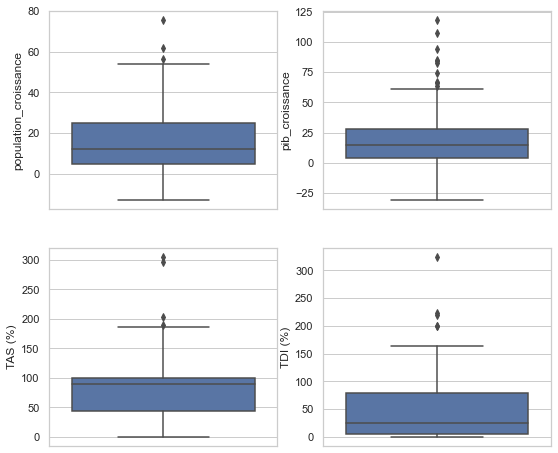

In [24]:
# Afficher des boxplot
plt.figure(figsize=(9, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=df,y='population_croissance')
plt.subplot(222)
sns.boxplot(data=df, y='pib_croissance')
plt.subplot(223)
sns.boxplot(data=df, y='TAS (%)')
plt.subplot(224)
sns.boxplot(data=df,y='TDI (%)')


<AxesSubplot:ylabel='Pib'>

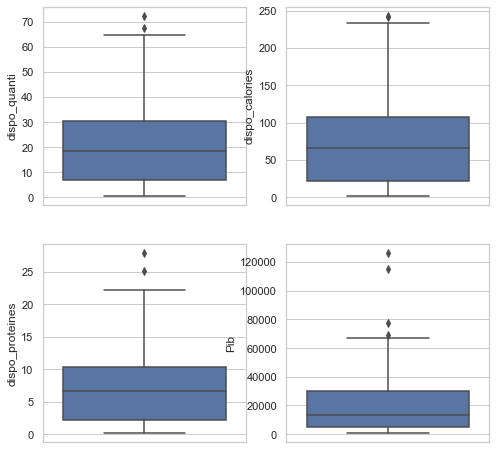

In [25]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=df,  y='dispo_quanti')
plt.subplot(222)
sns.boxplot(data=df,  y='dispo_calories')
plt.subplot(223)
sns.boxplot(data=df,  y='dispo_proteines')
plt.subplot(224)
sns.boxplot(data=df,  y='Pib')

<AxesSubplot:ylabel='stab_croissance'>

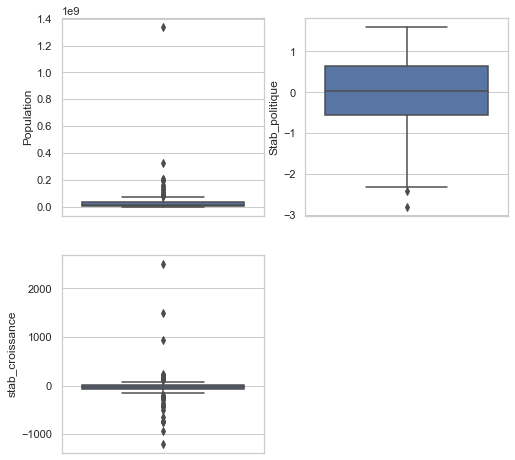

In [26]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=df,  y='Population')
plt.subplot(222)
sns.boxplot(data=df,  y='Stab_politique')
plt.subplot(223)
sns.boxplot(data=df,  y='stab_croissance')

In [27]:
# Afficher les valeurs extremes de la population
df.sort_values(by = ['Population'], ascending = False).head(20)

,Pays,dispo_quanti,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique
58,Inde,2.22,7.0,0.75,0.000000,96.831467,13.139,66.507,-33.913,1.338677e+09,6182.9,-0.76
147,États-Unis d'Amérique,55.68,219.0,19.93,0.673382,119.971532,8.142,8.161,-23.684,3.250848e+08,59914.8,0.29
101,Pakistan,5.86,20.0,1.97,0.156006,99.921997,23.895,30.254,-0.823,2.079062e+08,5091.1,-2.41
18,Brésil,48.03,204.0,15.68,0.030054,142.266079,9.311,2.936,30.556,2.078338e+08,14524.6,-0.47
95,Nigéria,1.01,2.0,0.31,0.000000,99.504950,30.431,16.413,-0.498,1.908732e+08,5190.4,-2.00
11,Bangladesh,1.50,7.0,0.47,0.000000,99.600000,11.934,84.077,-18.182,1.596854e+08,4894.6,-1.26
45,Fédération de Russie,30.98,104.0,10.44,4.960492,97.541703,1.580,3.854,-25.581,1.455301e+08,25926.4,-0.64
66,Japon,18.50,67.0,7.24,44.265010,91.718427,-0.772,8.944,9.901,1.275027e+08,41444.2,1.11
87,Mexique,32.52,123.0,9.26,23.038635,77.008770,14.296,7.040,9.589,1.247773e+08,19721.3,-0.80
105,Philippines,13.87,48.0,4.65,16.370809,83.629191,17.636,44.539,-25.625,1.051729e+08,8120.9,-1.19


#### SUPPRESSION DES OUTLIERS 

In [28]:
df=df.loc[(df['Population']<100000000)]

In [29]:
df.describe()

,dispo_quanti,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique
count,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,1.390000e+02,139.000000,139.000000
mean,20.727698,76.201439,7.342446,48.167063,78.752428,15.589165,19.244698,-42.256453,1.711996e+07,21109.243885,0.037122
std,15.614327,59.158615,5.549104,54.038997,50.855131,15.435261,23.502189,334.011023,2.153270e+07,21432.866698,0.829925
min,0.670000,2.000000,0.230000,0.000000,0.000000,-12.690000,-30.357000,-1200.000000,5.204500e+04,912.800000,-2.800000
25%,7.510000,25.000000,2.515000,5.305722,39.642857,4.389500,4.159000,-79.057000,2.308261e+06,5077.600000,-0.415000
50%,18.760000,66.000000,6.710000,29.629630,87.671233,12.225000,14.989000,-28.800000,7.698474e+06,13589.700000,0.070000
75%,29.640000,106.000000,10.220000,80.425532,100.000000,26.224500,27.831000,2.807000,2.450177e+07,30063.050000,0.695000
max,72.310000,243.000000,27.870000,323.928571,304.605263,75.598000,118.238000,2500.000000,9.644259e+07,126144.000000,1.600000


In [30]:
# Afficher les valeurs extremes de l'auto-suffisance
df.sort_values(by = ['TAS (%)'], ascending = False).head(10)

,Pays,dispo_quanti,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique
13,Belgique,12.65,44.0,4.57,222.368421,304.605263,6.751,4.086,-43.421,11419748.0,50442.3,0.43
104,Pays-Bas,20.33,70.0,8.48,163.440860,295.698925,3.118,1.824,17.949,17021347.0,55088.6,0.92
106,Pologne,30.30,107.0,12.14,4.757785,203.373702,-1.043,33.871,-23.529,37953180.0,30064.5,0.52
131,Thaïlande,12.95,47.0,4.35,0.227015,190.238365,4.575,27.790,-32.432,69209810.0,17423.0,-0.75
57,Hongrie,25.27,104.0,9.80,21.804511,185.338346,-2.936,13.554,8.000,9729823.0,29501.1,0.81
21,Bélarus,27.98,95.0,9.41,7.924528,174.716981,-0.319,15.137,-114.706,9450231.0,18356.1,-0.05
77,Lituanie,28.19,96.0,9.74,53.658537,143.902439,-12.690,25.614,-4.878,2845414.0,33761.9,0.78
124,Slovénie,24.41,83.0,8.72,38.461538,138.461538,3.194,0.751,-20.909,2076394.0,36507.6,0.87
50,Grèce,15.32,53.0,6.32,44.382022,138.202247,-4.954,-24.119,-113.462,10569450.0,28604.9,-0.07
34,Croatie,10.77,37.0,4.06,53.333333,135.555556,-4.116,3.059,15.000,4182857.0,27154.1,0.69


In [31]:
df=df.loc[(df['TAS (%)']<200)]

In [32]:
df=df.loc[(df['TDI (%)']<160)]

In [33]:
df = df.reset_index()
df = df.iloc[:,1:14]
df

,Pays,dispo_quanti,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique
0,Afghanistan,1.53,5.0,0.54,50.877193,49.122807,33.931,29.638,16.183,36296113.0,2058.4,-2.80
1,Afrique du Sud,35.69,143.0,14.11,24.268178,78.706327,16.063,9.757,-227.273,57009756.0,13860.3,-0.28
2,Albanie,16.36,85.0,6.26,80.851064,27.659574,-4.938,26.207,-290.000,2884169.0,12771.0,0.38
3,Algérie,6.38,22.0,1.97,0.722022,99.277978,21.138,10.470,-20.000,41389189.0,11737.4,-0.92
4,Allemagne,19.47,71.0,7.96,48.418631,87.061530,1.699,11.559,-41.000,82658409.0,53071.5,0.59
...,...,...,...,...,...,...,...,...,...,...,...,...
127,Zambie,3.42,11.0,1.15,20.000000,81.666667,34.797,26.847,-58.333,16853599.0,3485.0,0.15
128,Zimbabwe,4.68,16.0,1.59,7.894737,90.789474,16.161,118.238,-36.036,14236595.0,3795.6,-0.71
129,Égypte,12.96,50.0,4.51,8.800000,89.440000,23.277,12.813,158.182,96442591.0,11014.5,-1.42
130,Émirats arabes unis,43.47,147.0,14.80,105.097087,11.650485,53.792,-2.347,-36.735,9487203.0,67183.6,0.62


In [34]:
# Enregistrement le fichier en CSV pour l'utiliser dans le notebook de clusterisation 
df.to_csv('df_final.csv')

## Triangle de Correlation 

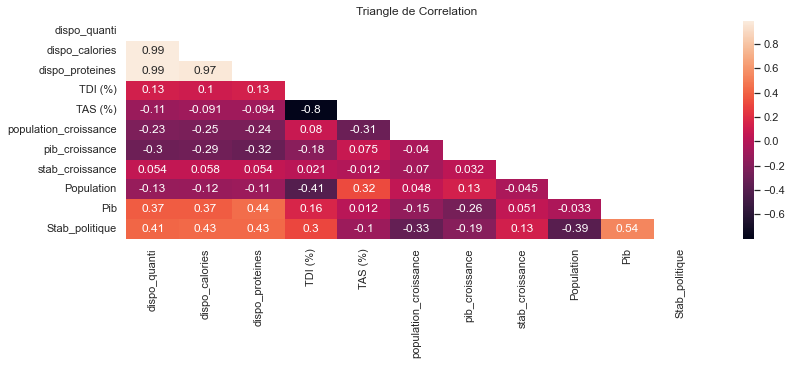

In [35]:
# Calculer la corrélation par paires des colonnes (methode de pearson)
matrix = df.corr()

# Triangle de corrélations
## Création de la forme du triangle avec la fonction triu
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

plt.figure(figsize=(13, 4))
sns.heatmap(matrix, mask=mask, annot=True)
plt.title("Triangle de Correlation")
plt.show()

Dispo quanti écarté :
    - Forte corrélation avec dispo en protéine 
    - Même corrélation que dispo calories




# 2 - ANALYSE EN COMPOSANTES PRINCIPALES (ACP)

In [36]:
pays = ['Pays']
names= df['Pays'].values
df_sans_pays = df.drop(pays + ['dispo_quanti'], axis=1)

In [37]:
# Selectionner les valeurs à utiliser pour notre analyse
X = df_sans_pays.values
#Centrage / réduction des données pour que nos données puissent prendre la même importance
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
#Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
Z = linkage(X_scaled, method = 'ward', metric='euclidean')

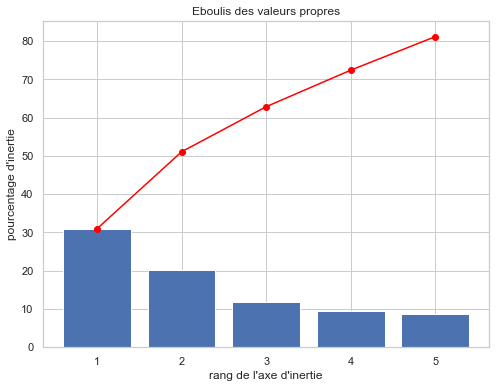

In [38]:
# choix du nombre de composantes à calculer
n_comp = 5
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)
# Eboulis des valeurs propres
figure1 = plt.figure(figsize=(8,6))
display_scree_plot(pca)
plt.show()

In [39]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([31.  , 20.11, 11.78,  9.54,  8.77])

##### OBSERVATIONS
Nous avons dans notre cas l'inertie totale répartie inéquitablement sur 5 axes

 - Axe 1 : 31,00 % de l'inertie totale
 - Axe 2 : 20.11 % de l'inertie totale
 - Axe 3 : 11.78 % de l'inertie totale
 - Axe 4 : 9.54 % de l'inertie totale
 - Axe 5 : 8.77 % de l'inertie totale

###  Components

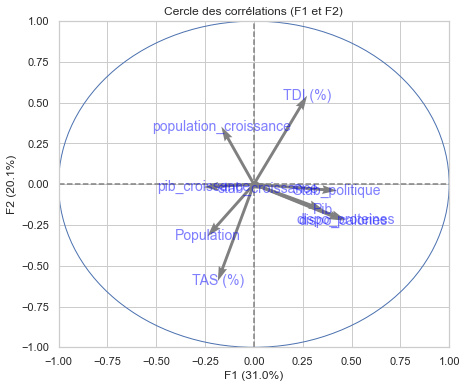

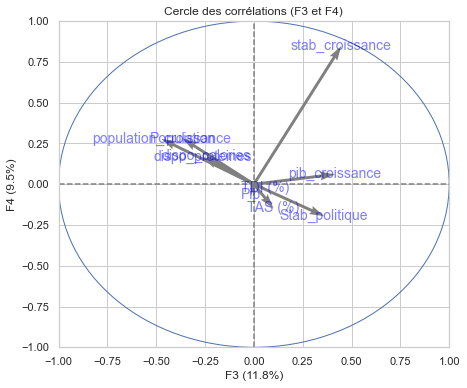

In [40]:
# selection des colonnes à prendre en compte dans l'ACP
features = df_sans_pays.columns
# Cercle des corrélations
pcs = pca.components_
X_projected = pca.transform(X_scaled)
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features) )
plt.show()

In [41]:
# création de la matrice de corrélation
t=pca.components_[:]
df_corr_comp = pd.DataFrame(t,index = ['F1', 'F2', 'F3','F4','F5'],columns=df_sans_pays.columns)
df_corr_comp.round(2)

,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique
F1,0.46,0.47,0.27,-0.18,-0.17,-0.26,0.07,-0.24,0.36,0.42
F2,-0.22,-0.22,0.54,-0.59,0.35,-0.02,-0.03,-0.32,-0.16,-0.04
F3,-0.24,-0.26,0.06,0.10,-0.47,0.41,0.45,-0.36,-0.02,0.36
F4,0.17,0.17,-0.02,-0.15,0.28,0.06,0.85,0.28,-0.07,-0.20
F5,-0.38,-0.32,-0.04,0.21,0.25,-0.54,0.21,0.04,0.52,0.21


<AxesSubplot:>

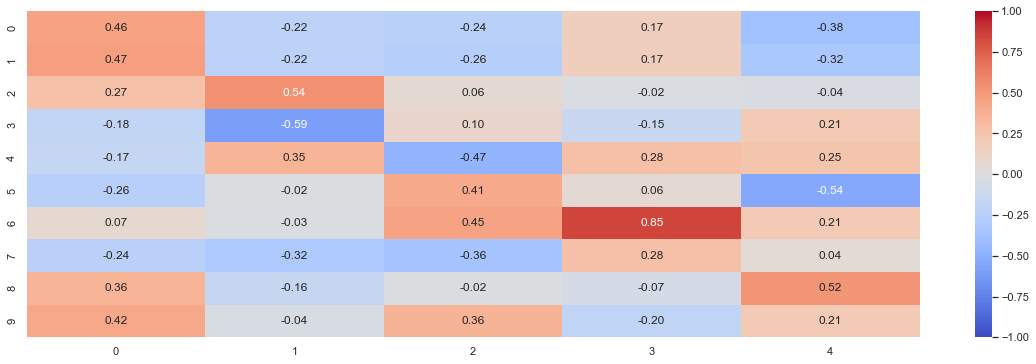

In [42]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

##### OBSERVATIONS : 
 - F1 : Variables corrélées positivement:

     - Toutes les disponibilités sont corrélées (0.45), on peut dire que l'axe F1 représente les disponibilités
 - F2 :

    - variables corrélées positivement : Le TDI est fortement corrélé (0.54)
    - variables corrélées négativement : Le TAS est fortement corrélé (- 0,59)
     On peut dire que les pays avec un fort TDI ont une tendance positive en terme de croissance démographique et un faible TAS

 - F3 :

    - La croissance du pib est fortement corrélé (0.41) à l'inverse de la croissance de la population (-0.47)
 - F4 :

    - variables corrélées positivement : Croissance de la stabilité politique (0.84)
    
     On peut dire que sur cet axe les pays avec un fort TDI ont également une tendance positive en terme de TAS

Nous utiliserons dans ce cas les 2 premières composantes F1 et F2 pour notre analyse

In [43]:
# Récupération du cluster de chaque individu
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')  
clusters = pd.DataFrame(cluster.fit_predict(X_projected)+1, columns = ['clusters'])

In [44]:
result = pd.DataFrame(X_projected)
recup = pd.merge(result, clusters, left_index=True, right_index=True)
recup = pd.merge(recup, df['Pays'] , left_index=True, right_index=True)

In [45]:
# Moyenne par cluster de chaque composante issue de l'ACP (centroïdes)
centroides = recup.groupby(['clusters']).mean().reset_index()
centroides['clusters'] = 'centroïde'
centroides['Pays'] = 'centroïde'
centroides

,clusters,0,1,2,3,4,Pays
0,centroïde,0.889295,-0.830628,0.520962,-0.135815,0.328086,centroïde
1,centroïde,-1.526117,-0.338859,-0.335223,-0.037763,-0.252232,centroïde
2,centroïde,2.761046,1.295722,-0.892055,0.585278,-0.069601,centroïde
3,centroïde,-0.421127,2.267457,0.291180,-0.011668,-0.127549,centroïde


In [57]:
# Jointure des centroïdes sur la dataframe
composantes_centroides = pd.concat([recup, centroides])
composantes_centroides = composantes_centroides.reset_index()
composantes_centroides = composantes_centroides.iloc[:,1:8]
composantes_centroides

,0,1,2,3,4,clusters,Pays
0,-3.193074,1.482467,-1.236543,1.127445,-0.299065,2,Afghanistan
1,0.345119,-1.269807,-1.831764,0.524088,-0.858096,2,Afrique du Sud
2,0.779317,1.079812,0.783927,-1.077851,-1.037622,1,Albanie
3,-2.117796,-0.573559,-0.608658,0.302635,0.727364,2,Algérie
4,0.377507,-1.582406,-0.551325,0.290925,1.064296,1,Allemagne
...,...,...,...,...,...,...,...
131,-0.594825,-0.750148,-0.220312,-0.143142,0.078578,2,Équateur
132,0.889295,-0.830628,0.520962,-0.135815,0.328086,centroïde,centroïde
133,-1.526117,-0.338859,-0.335223,-0.037763,-0.252232,centroïde,centroïde
134,2.761046,1.295722,-0.892055,0.585278,-0.069601,centroïde,centroïde


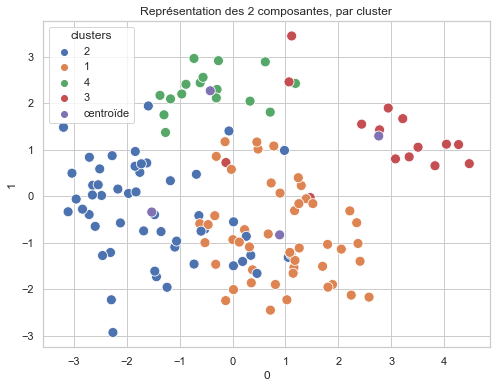

In [65]:
# Scatterplot des 2 composantes
plt.figure(figsize=(8,6))
sns.scatterplot(data=composantes_centroides, x=0, y=1, hue='clusters', s=100,palette="deep")

#def label_point(x, y, val, ax):
#    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#   for i, point in a.iterrows():
#        ax.text(point['x']+.02, point['y'], str(point['val']))

#label_point(composantes_centroides[0], composantes_centroides[1], composantes_centroides['Pays'], plt.gca())
plt.title('Représentation des 2 composantes, par cluster')
plt.show()

Text(0.5, 0, 'F3')

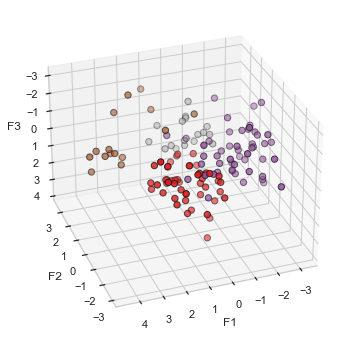

In [48]:
# On définit notre figure et notre axe différemment : 
fig= plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

# On affiche nos points : 
ax.scatter(
    recup.iloc[:, 0],
    recup.iloc[:, 1],
    recup.iloc[:, 2],
    c=clusters, cmap="Set1", edgecolor="k", s=40)

# On spécifie le nom des axes : 
ax.set_xlabel("F1")
ax.set_ylabel("F2")
ax.set_zlabel("F3")


In [49]:
# Jointure des données non normalisées avec les clusters et coordonnées de l'ACP
df = pd.merge(df, recup, how='left', on='Pays')
df.sample(3)

,Pays,dispo_quanti,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique,0,1,2,3,4,clusters
50,Honduras,21.73,93.0,6.98,5.853659,94.146341,20.753,10.983,27.273,9429013.0,5562.0,-0.56,-0.635734,-0.416340,-0.374630,0.315544,-0.175824,2
12,Belize,25.69,110.0,8.26,0.000000,105.263158,25.665,-2.709,-78.947,375769.0,7140.9,0.04,0.019007,-0.550157,-0.609979,-0.103570,0.192203,2
64,Koweït,46.25,156.0,15.87,72.486772,29.629630,61.984,-30.357,-108.065,4056099.0,50855.6,-0.05,2.438220,1.550033,-3.007147,0.923350,1.230362,3


In [50]:
# Moyenne des variables non standardisées, par cluster
groupes_centroides = df.groupby(['clusters']).mean().reset_index()

# Enregistrement de la liste des pays et clusters en CSV
groupes_centroides

,clusters,dispo_quanti,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique,0,1,2,3,4
0,1,25.264898,92.775510,9.259592,34.705968,95.474633,3.897163,12.394714,61.402102,1.414164e+07,32339.655102,0.546531,0.889295,-0.830628,0.520962,-0.135815,0.328086
1,2,13.962549,52.803922,4.670196,13.654175,92.904079,20.516627,30.529176,-157.288275,2.786194e+07,9126.211765,-0.658431,-1.526117,-0.338859,-0.335223,-0.037763,-0.252232
2,3,42.567333,156.666667,14.682000,91.782342,15.486430,27.492467,0.546000,20.896533,4.365189e+06,39317.446667,0.653333,2.761046,1.295722,-0.892055,0.585278,-0.069601
3,4,9.621176,31.058824,3.341765,93.355031,25.922157,24.549824,23.351941,-42.420176,7.206046e+06,5352.476471,-0.042941,-0.421127,2.267457,0.291180,-0.011668,-0.127549


### KMeans sur dimension de l'ACP :

Text(0, 0.5, 'WCSS')

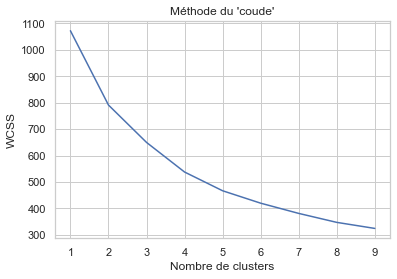

In [51]:
#Determination du nombre optimal de clusters pour le K-means sur les dimensions de l'ACP: methode du coude:

#calculs:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_projected)
    wcss.append(kmeans.inertia_)

#Graphique:
plt.plot(range(1, 10), wcss)
plt.title("Méthode du 'coude'")
plt.xlabel("Nombre de clusters")
plt.ylabel('WCSS')

#PROBLEME: choisir une autre méthode?

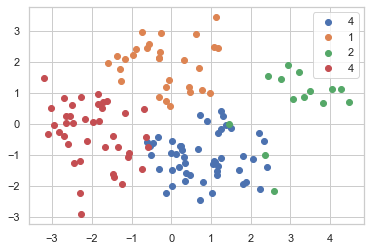

Text(0.5, 1.0, 'Projection des 4 centres sur le 1e plan factoriel')

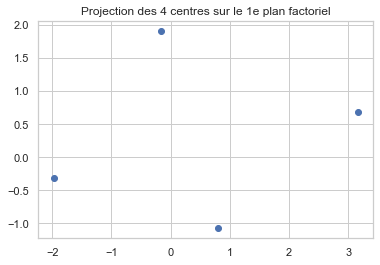

In [52]:
# Nombre de clusters:
n_clust_km_acp = 4

# Clustering par K-means:
km_acp = KMeans(n_clusters=n_clust_km_acp)
km_acp.fit(X_projected)

# Ajout d'une colonne contenant le cluster attribue (+1 pour ne pas avoir des cluster 0):
clusters_km_acp = km_acp.labels_+1                              

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca_km = decomposition.PCA(n_components=2).fit(X_projected)
acp_km = PCA(n_components=2).fit_transform(X_projected)
for k in [0,1,2,3]:
    plt.scatter(acp_km[km_acp.labels_==k,0],acp_km[km_acp.labels_==k,1])
    plt.legend(clusters_km_acp)
plt.show()

#PROBLEME chager couleurs (c=)
#PROBLEME pas annoté (surtout)

# Affichage des positions des centres de classes
plt.figure()
centroids_km_acp = km_acp.cluster_centers_
centroids_km_acp_projected = pca_km.transform(centroids_km_acp)
plt.scatter(centroids_km_acp_projected[:,0],centroids_km_acp_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids_km_acp)))

In [53]:
df_clusters_km_acp = pd.DataFrame(clusters_km_acp)
df_clusters_km_acp = df_clusters_km_acp.rename(columns={ 0:'Cluster_km_acp'})
df_clusters_km_acp


df_clusters_km_acp_c = pd.merge(df_clusters_km_acp, df['Pays'] , left_index=True, right_index=True)
df_clusters_km_acp_c

# Jointure des données non normalisées avec les clusters et coordonnées de l'ACP
df = pd.merge(df, df_clusters_km_acp_c, how='left', on='Pays')
df.sample(3)

,Pays,dispo_quanti,dispo_calories,dispo_proteines,TDI (%),TAS (%),population_croissance,pib_croissance,stab_croissance,Population,Pib,Stab_politique,0,1,2,3,4,clusters,Cluster_km_acp
62,Kirghizistan,3.10,11.0,1.08,78.125000,21.875000,19.392,21.836,-61.616,6189733.0,5046.7,-0.38,-0.959217,2.198213,0.430140,-0.193283,-0.020458,4,2
114,Suède,16.60,61.0,7.09,44.919786,83.957219,8.097,6.683,-22.835,9904896.0,51948.0,0.98,1.171804,-0.309324,0.647932,-0.628053,1.319470,1,1
24,Chili,36.36,153.0,12.21,23.065476,105.952381,11.738,21.134,2.439,18470439.0,24411.5,0.42,1.051450,-1.314120,-0.149681,0.228275,-0.501466,2,1


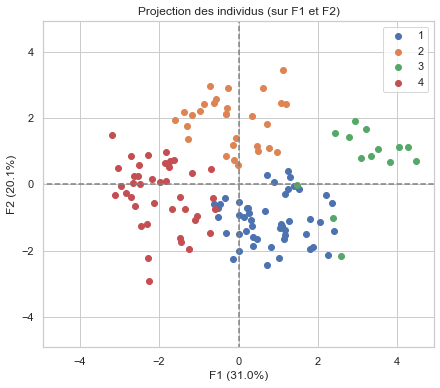

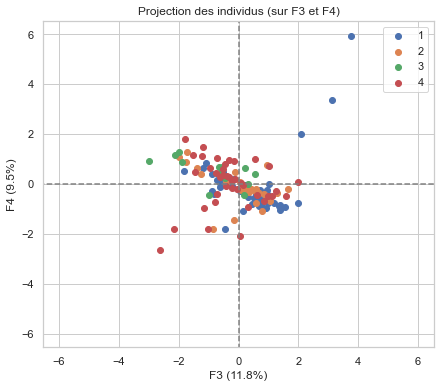

<Figure size 720x720 with 0 Axes>

In [54]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes_2(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var = df['Cluster_km_acp'], alpha = 1)
figure3 = plt.figure(figsize=(10,10))
plt.show()

In [55]:
df_centroids_km_acp = pd.DataFrame(km_acp.cluster_centers_)
df_centroids_km_acp.round(2)

,0,1,2,3,4
0,0.80,-1.07,0.45,-0.09,0.26
1,-0.16,1.91,0.05,-0.11,-0.13
2,3.16,0.69,-0.82,0.51,-0.39
3,-1.97,-0.31,-0.30,0.02,-0.08


In [56]:
centroides.iloc[:,2:6].round(2)

,1,2,3,4
0,-0.83,0.52,-0.14,0.33
1,-0.34,-0.34,-0.04,-0.25
2,1.30,-0.89,0.59,-0.07
3,2.27,0.29,-0.01,-0.13


In [71]:
df.loc[df['Cluster_km_acp']==2]['Pays']

2                   Albanie
5                    Angola
8                   Arménie
15                 Botswana
19                    Bénin
20               Cabo Verde
28                    Congo
41                    Gabon
42                    Ghana
46                   Guinée
47            Guinée-Bissau
49                  Géorgie
53                     Iraq
59                 Jordanie
60               Kazakhstan
62             Kirghizistan
63                 Kiribati
65                  Lesotho
68                  Libéria
71        Macédoine du Nord
78               Mauritanie
79                 Mongolie
80               Monténégro
83                  Namibie
89                     Oman
106    Sao Tomé-et-Principe
108            Sierra Leone
113                Suriname
125                 Vanuatu
Name: Pays, dtype: object

##### OBSERVATIONS
Nous observons sur le plan 1 le groupe 2 (orange) qui se présente bien sur l'axe F1 en partie positive du TDI et négative de l'axe F1 (disponibilités).

Ce cluster présente bien les critères suivants :

 - TDI élévé
 - TAS faible
 - Croissance démographique relativement élevée
 - Des disponibilités très faibles
 - Population faible mais population croissante.
 - PIB élevé
 
 
 Liste des Pays: 
 
-                 Albanie
-                   Angola
-                Arménie
-                Botswana
-                  Bénin
-            Cabo Verde
-                Congo
-               Gabon
-              Ghana
-            Guinée
-    Guinée-Bissau
-         Géorgie
-           Iraq
-      Jordanie
-  Kazakhstan
-             Kirghizistan
-                Kiribati
-                Lesotho
-               Libéria
-    Macédoine du Nord
-          Mauritanie
-           Mongolie
-       Monténégro
-          Namibie
-           Oman
-   Sao Tomé-et-Principe
-         Sierra Leone
-              Suriname
-              Vanuatu